### Import libraries, load model...

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import argparse
from torch.serialization import save
from transformers_interpret import SequenceClassificationExplainer
import matplotlib.pyplot as plt

from kmembert.models import HealthBERT
from kmembert.utils import create_session

In [2]:
# Import argparse
import argparse
parser = argparse.ArgumentParser()
parser.add_argument("-d", "--data_folder", type=str, default="data/ehr/test.csv", 
    help="data path to access to the testing file")
parser.add_argument("-p", "--path_dataset", type=str, default="data/ehr/test.csv", 
    help="data path to access to the testing file")
parser.add_argument("-r", "--resume", type=str, default="kmembert-base", 
    help="result folder in with the saved checkpoint will be reused")
parser.add_argument("-nr", "--nrows", type=int, default=10, 
    help="maximum number of samples for testing")
parser.add_argument("-f", "--folder_to_save", type=str, default="graphs", 
    help="folder to save the figures")
parser.add_argument("-ng", "--noigr", type=int, default=2, 
    help="The Noigr of a patient")
args = parser.parse_args("")

In [3]:
# Load Model
_, _, device, config = create_session(args)
model = HealthBERT(device, config)

> DEVICE:  cpu
> ROOT:    c:\Users\DIPIAZZA\Documents\CLBProjet\VirtualMachine_T2\KmemBERT
> SESSION: c:\Users\DIPIAZZA\Documents\CLBProjet\VirtualMachine_T2\KmemBERT\results\ipykernel_launcher_22-06-28_09h56m51s

Using mode density (Health BERT checkpoint kmembert-base)

Loading camembert and its tokenizer...
if config.resume from health_bert.py
Resuming with model at kmembert-base...
Successfully loaded



### Read data and Select text to study

In [4]:
# Read df used to test
# Creation du jeu de donnees pour retrouver les infos interessantes
test = pd.read_csv("kmembert\\Visualization\\test_VM.csv")

# Read df with prediction
res_pred = pd.read_csv("kmembert\\Visualization\\results_pred_VM.csv")

# Merge 2 dataframes
resul_df = pd.merge(test, res_pred, left_on="indice", right_on="ind")[['Noigr', 'Date cr', 'Date deces', 'Texte', 'indice', 'pred', 'lab']]

# Add columns to have absolute error between pred and lab
resul_df['ecart'] = abs(resul_df['pred']-resul_df['lab'])

resul_df['nb_words'] = resul_df['Texte'].apply(lambda x: len(x.split()))

resul_df['nb_docs'] = resul_df.groupby(["Noigr"])["Noigr"].transform("count")

resul_df = resul_df.sort_values("ecart", ascending=False)

In [5]:
# Header of data to help us in selection of texts
resul_df.head(4)

,Noigr,Date cr,Date deces,Texte,indice,pred,lab,ecart,nb_words,nb_docs
4582,4443257,20040123,20150122,"Poids actuel = 81,0 kg, Poids il y a 6 mois = ...",4582,0.069860,0.983240,0.913380,80,66
4581,4443257,20040120,20150122,On revoit le patient pour la perspective d'inc...,4581,0.084283,0.983344,0.899061,51,66
4579,4443257,20020326,20150122,Patient de 52 ans adressé au Centre par le Dr ...,4579,0.084770,0.983469,0.898699,126,66
4347,925180,20011107,20080419,"Il s'agit d'un patient âgé de 62 ans, présenté...",4347,0.077899,0.947332,0.869434,126,25


In [ ]:
resul_df['PS_flag_4'] = resul_df['Texte'].apply(lambda x: "PS = 4" in x)
resul_df['PS_flag_3'] = resul_df['Texte'].apply(lambda x: "PS = 3" in x)
resul_df['PS_flag_2'] = resul_df['Texte'].apply(lambda x: "PS = 2" in x)
resul_df['PS_flag_1'] = resul_df['Texte'].apply(lambda x: "PS = 1" in x)
resul_df['PS_flag_0'] = resul_df['Texte'].apply(lambda x: "PS = 0" in x)

In [ ]:
sns.boxplot(x='PS_flag', y='lab', data=resul_df_PS, order=['PS_0', 'PS_1', 'PS_2', 'PS_3', 'PS_4'], palette='rocket_r')
plt.title("BoxPlot - Survival label per Performance Status")

In [ ]:
sns.boxplot(x='PS_flag', y='pred', data=resul_df_PS, order=['PS_0', 'PS_1', 'PS_2', 'PS_3', 'PS_4'], palette='rocket_r')
plt.title("BoxPlot - Survival prediction per Performance Status")

In [ ]:
# Test Statistique sur les différences de temps de survie des patients
'''
# create a list of our conditions
conditions = [
    (resul_df['PS_flag_0'] == True),
    (resul_df['PS_flag_1'] == True),
    (resul_df['PS_flag_2'] == True),
    (resul_df['PS_flag_3'] == True),
    (resul_df['PS_flag_4'] == True),
    ]

# create a list of the values we want to assign for each condition
values = ['PS_0', 'PS_1', 'PS_2', 'PS_3', 'PS_4']

resul_df['PS_flag'] = np.select(conditions, values)
resul_df_PS = resul_df[resul_df.PS_flag != '0']

from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(x='PS_flag', y='lab', data=resul_df_PS, order=['PS_0', 'PS_1', 'PS_2', 'PS_3', 'PS_4'])
plt.title("BoxPlot - Survival label per Performance Status")

a = resul_df_PS[resul_df_PS.PS_flag=='PS_0']['lab']
b = resul_df_PS[resul_df_PS.PS_flag=='PS_1']['lab']
c = resul_df_PS[resul_df_PS.PS_flag=='PS_2']['lab']
d = resul_df_PS[resul_df_PS.PS_flag=='PS_3']['lab']
e = resul_df_PS[resul_df_PS.PS_flag=='PS_4']['lab']
stats.kruskal(a, b, c, d, e)
stats.f_oneway(a, b, c, e, e)'''

In [11]:
# Select Noigr and Indice's CR to select text to study
id_noigr = 19524962
id_indice = 1222
resul_df[(resul_df.Noigr==id_noigr) & (resul_df.indice<=id_indice) & (resul_df.indice>id_indice-4)].sort_values("indice")

,Noigr,Date cr,Date deces,Texte,indice,pred,lab,ecart,nb_words,nb_docs
1219,19524962,20200221,20200711,"Karnofsky = 90 %, PS = 1, Poids actuel = 54,8 ...",1219,0.185090,0.161592,0.023498,286,12
1220,19524962,20200306,20200711,"Karnofsky = 90 %, PS = 1, Poids actuel = 54,0 ...",1220,0.146953,0.146790,0.000163,208,12
1221,19524962,20200313,20200711,"Karnofsky = 90 %, PS = 1, Poids actuel = 55,0 ...",1221,0.151112,0.139292,0.011820,244,12
1222,19524962,20200403,20200711,"Karnofsky = 80 %, PS = 1, Poids actuel = 54,0 ...",1222,0.117598,0.116399,0.001199,263,12


In [12]:
# Create a list texts_to_classify which contains CR texts to classify
texts_to_classify = resul_df[(resul_df.Noigr==id_noigr) & (resul_df.indice<=id_indice) & (resul_df.indice>id_indice-4)].sort_values("indice").Texte.values
import math
n_max = 1500
for i in range(len(texts_to_classify)):
    if(len(texts_to_classify[i])>n_max):
        texts_to_classify[i] = texts_to_classify[i][:n_max]
#texts_to_classify = texts_to_classify[0]
#texts_to_classify

In [13]:
texts_to_classify

array(["Karnofsky = 90 %, PS = 1, Poids actuel = 54,8 kg, Indice masse corporelle = 19,19 kg/m².  Patient vu en hôpital de jour pour C8-J1 dansTROPHY IMMU-132 à 75% de dose pour un carcinome urothélial des cavités pyélocalicielles gauches, métastatique ganglionnaire sus-claviculaire, rétro-péritonéal, psoas, ganglionnaire médiastinal, plancher vésical.  Le patient va très bien. Il note une nette amélioration de son état général depuis la reprise de son insulinela semaine dernière. Aucune nausée pendant cette intercure. Il s'est bien hydraté et n'a pas souhaité continuer les perfusions par NaCl1L la nuit à domicile. Amélioration également de sa dysphonie. Quelques douleurs au niveau de la hanche droitelors des injection de G-CSF. Aucune autre plainte fonctionnelle par ailleurs.  A l'examen clinique : - Poids en hausse à 54,8 kg, poursuite des compléments nutritionnels deux fois par jour. - Auscultation cardiaque et pulmonaire sans anomalie. - Abdomen souple etnon douloureux sans masse p

In [28]:
texto = "Evolutivité de la maladie : Réponse complète persistante. On revoit la patiente en visite de surveillance deux ans après le traitement initial.  Elle va bien, pas de plainte fonctionnelle particulière, bonne tolérance aux anti-aromatases avec des effets secondaires qui restent très modérés.  A l'examen clinique, aucune anomalie de la paroi thoracique droite, palpation mammaire gauche normal, pas d'adénopathie périphérique, pas d'hépatomégalie, auscultation pulmonaire normale.  La mammographie réalisée ce jour est classée ACR2 sans modification des images calciques connues."
texts_to_classify = np.array([texto])

### Full Function which can read texts to classify 

-------------------------------------------------------------------------------------------------
##### Print with SD

In [65]:
# Print By Mean With Sum as a tick
from collections import OrderedDict

# Read medical vocabulary
import json
f = open("medical_voc/large.json", encoding='utf-8')
dictio = json.load(f)
med_voc = []
for i in range(len(dictio)):
    med_voc.append(dictio[i][0])
################################################################
# Filter on too long docs, otherwise there will not be read
n_max = 1500
# For Loop on text to classify ["text1..", ..., "text4.."]
for i in range(len(texts_to_classify)):
    # If length is too long, select only 1500 first caracters
    if(len(texts_to_classify[i])>n_max):
        n_remove = (len(texts_to_classify[i])-n_max)/2
        texts_to_classify[i] = texts_to_classify[i][n_remove:(n_remove+n_max)]
################################################################
# For each 'clean' text, compute word attributions
word_attributes = []
for ehr in texts_to_classify:
    cls_explainer = SequenceClassificationExplainer(
        model.camembert,
        model.tokenizer)
    word_attributions = cls_explainer(ehr)
    word_attributes+= [dict(word_attributions)]

# Compute word importance by sum
result = {}
n_documents = len(word_attributes)
for d in word_attributes:
    for k in d.keys():
        # Si key presente, ajout de la valeur
        if k in result:
            result[k].append(d[k]/n_documents)
        # Sinon, création de la liste puis ajout de la valeur
        else:
            result[k] = []
            result[k].append(d[k]/n_documents)

In [66]:
# Compute standart deviation for each token
result_sd = {}
for k, v in result.items():
    result_sd[k] = np.std(v)

In [67]:
# Create dict to stock word+attributions for words in medical voc
result_medicam = {}
result_medicam_sd = {}
# For each word of the text to classify
for k, v in result.items():
    # If special character present, replace it with lower case
    new_k = k
    if("▁" in k):
        new_k = k.replace("▁", "").lower()
    elif("_" in k):
        new_k = k.replace("_", "").lower()
    # Add word to dict with transformed string, if in medical voc
    if new_k in med_voc:
        result_medicam[new_k] = v
        result_medicam_sd[new_k] = result_sd[k]

In [68]:
# Compute mean of word importance
result_mean = {k: np.mean(result_medicam[k]) for k in result_medicam.keys() & result_medicam}

# Get 10 most important by mean
show_n = 10
final_dict = dict(sorted(result_mean.items(), key=lambda item: abs(item[1]), reverse=True)[:show_n])

# Get 10 most importants word with values as sum
final_dict_sd = dict((k, result_medicam_sd[k]) for k in list(final_dict.keys()))

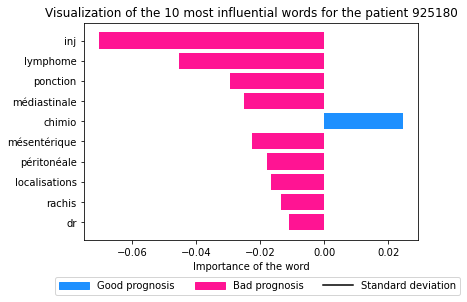

In [69]:

# Plot the results for the word attributes (green for positive contribution and red for negative contribution)
x = list(final_dict.keys())
y = list(final_dict.values())
colors = ['deeppink']*show_n 
colors = ['deeppink']*len(y) 
for i in range(len(y)):
    if y[i]>0:
        colors[i] = 'dodgerblue'
fig, ax = plt.subplots()
plt.barh(list(reversed(x)), list(reversed(y)), color=list(reversed(colors)))

i = show_n-1
for k, v in final_dict.items():
    if(final_dict_sd[k] != 0):
        if(v>=0):
            ax.hlines(y=i, xmin=final_dict[k]-final_dict_sd[k], xmax=final_dict[k]+final_dict_sd[k], linewidth=1, colors='black')
            ax.vlines(x=final_dict[k]-final_dict_sd[k], ymin=i-0.2, ymax=i+0.2, linewidth=1, color='black')
            ax.vlines(x=final_dict[k]+final_dict_sd[k], ymin=i-0.2, ymax=i+0.2, linewidth=1, color='black')
        else:
            ax.hlines(y=i, xmin=final_dict[k]-final_dict_sd[k], xmax=final_dict[k]+final_dict_sd[k], linewidth=1, colors='black')
            ax.vlines(x=final_dict[k]-final_dict_sd[k], ymin=i-0.2, ymax=i+0.2, linewidth=1, color='black')
            ax.vlines(x=final_dict[k]+final_dict_sd[k], ymin=i-0.2, ymax=i+0.2, linewidth=1, color='black')
    i -= 1

plt.title(f'Visualization of the 10 most influential words for the patient {id_noigr}')

# Add legend
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
blue_patch = mpatches.Patch(color='dodgerblue')
pink_patch = mpatches.Patch(color='deeppink')
line_b, = plt.plot([0], [0], color='black')

plt.xlabel("Importance of the word")

plt.legend([blue_patch, pink_patch, line_b], 
            ['Good prognosis', 'Bad prognosis', 'Standard deviation'], 
            numpoints=1, handlelength=3,
            loc='lower left',
            bbox_to_anchor=(-0.1, -0.275), ncol=3)

plt.savefig(f'graphs/interpretation/test_{id_noigr}_boxplotSD.png', bbox_inches='tight')

-----------------------------------------------------------------------------------
##### Plot with Text

In [71]:
# Compute mean of word importance
result_mean = {k: result[k][0] for k in result.keys() & result}
result_mean = dict((k, result_mean[k]) for k in list(result.keys()))

In [72]:
# Plot text with highlights
import shap
# Modification du dictionnaire pour afficher les résultats
# Création de result_plot pour stocker tous les mots et leur valeur d'attributions
result_plot = {}
# Pour chaque mot et sa valeur extraite des textes à classifier
for k, v in result_mean.items():
    new_k = k
    #  If special character present, replace it and save with lower case
    if("▁" in k):
        new_k = k.replace("▁", "")
        result_plot[new_k] = 0
    elif("_" in k):
        new_k = k.replace("_", "")
        result_plot[new_k] = 0
    result_plot[new_k] = -v # Negative to adjust shap module, idk why...

# Mise en forme pour affichage
txt = list(result_plot.keys()) # Le texte
txt_data = (list(map(( lambda x: x+' '), txt)),)
val = list(result_plot.values()) # Les valeurs
txt_values = np.array([val])

# Création de l'objet shap et affichage
test = shap._explanation.Explanation(values=txt_values)
test.data = txt_data
test.base_values = np.array([0.])
shap.plots.text(test[0])

In [73]:
# 925180 Plot text with highlights - Modifications manuelles
# Patient 925180 - 4347
texto = "Il s'agit d'un patient âgé de 62 ans, présenté par le Dr DUBOURDEAU, qui présente un lymphome agressif B diffus à grandes cellules à localisations amygdalienne droite et cervicale droite. Le scanner a montré de multiples localisations médiastinales, rétro-péritonéales et mésentériques. Il existe par ailleurs des douleurs des membres inférieurs et une atteinte clinique au niveau de L4. La ponction lombaire n'a pas retrouvé de cellules anormales mais une hyperprotéinorachis à 1,23 g/l. Une IRM lombo-sacrée est prévue. Le patient, semble-t-il, est en assez mauvais état général et il n'est pas certain qu'il supporte ue chimiothérapie de type ACVB. Nous proposerions cependant au moins de réaliser une chimiothérapie de type MCOPA. Il est important, par ailleurs, de réaliser la prophylaxie neuro-méningée par injection intratéchale de METHOTREXATE."
texts_to_classify = np.array([texto])
result_plot = {key if key != 'OUR' else 'DOCTOR_NAME': value for key, value in result_plot.items()}
del result_plot['DU'], result_plot['B'], result_plot['D'], result_plot['EAU']

result_plot = {key if key != 'ienne' else 'amygdalienne': value for key, value in result_plot.items()}
del result_plot['g'], result_plot['dal']

result_plot = {key if key != 'existe' else '. Il existe': value for key, value in result_plot.items()}

result_plot = {key if key != 'hyper' else 'hyperprotéinorachis': value for key, value in result_plot.items()}
del result_plot['a'], result_plot['my']

result_plot = {key if key != 'rée' else 'lombo-sacrée': value for key, value in result_plot.items()}
del result_plot['omb'], result_plot['o'], result_plot['sac']

result_plot = {key if key != 'proposer' else 'proposerions': value for key, value in result_plot.items()}
result_plot = {key if key != 'moins' else 'au moins': value for key, value in result_plot.items()}

result_plot = {key if key != 'CO' else 'MCOPA': value for key, value in result_plot.items()}
del result_plot['M'], result_plot['PA']

result_plot = {key if key != 'ing' else 'neuro-méningée': value for key, value in result_plot.items()}
del result_plot['neuro'], result_plot['mén']

result_plot = {key if key != 'inj' else 'injection': value for key, value in result_plot.items()}
del result_plot['ction']

result_plot = {key if key != 'té' else 'neuro-intratéchale': value for key, value in result_plot.items()}
del result_plot['chal'], result_plot['intra']

result_plot = {key if key != 'HO' else 'METHOTREXATE': value for key, value in result_plot.items()}
del result_plot['MET'], result_plot['X'], result_plot['ATE']

# Mise en forme pour affichage
txt = list(result_plot.keys()) # Le texte
txt_data = (list(map(( lambda x: x+' '), txt)),)
val = list(result_plot.values()) # Les valeurs
txt_values = np.array([val])

# Création de l'objet shap et affichage
test = shap._explanation.Explanation(values=txt_values)
test.data = txt_data
test.base_values = np.array([0.])
shap.plots.text(test[0])

In [51]:
'''# Patient 19131265
result_plot = {key if key != 'tivité' else 'Evolutivité ': value for key, value in result_plot.items()}
del result_plot['E'], result_plot['volu']


result_plot = {key if key != 'roma' else 'anti-aromatases': value for key, value in result_plot.items()}
del result_plot['anti'], result_plot['tas'], result_plot['es'], result_plot['-'], result_plot['a']

result_plot = {key if key != 'auc' else 'aucune': value for key, value in result_plot.items()}
del result_plot['une']

result_plot = {key if key != 'he' else 'gauche': value for key, value in result_plot.items()}
del result_plot['g']

result_plot = {key if key != 'roma' else 'anti-aromatases ': value for key, value in result_plot.items()}

result_plot = {key if key != 'd' else "pas d'": value for key, value in result_plot.items()}

result_plot = {key if key != 'CR2' else 'ACR2': value for key, value in result_plot.items()}

result_plot = {key if key != 'iques' else 'calciques': value for key, value in result_plot.items()}
del result_plot['calc']

result_plot = {key if key != 'modéré' else 'modérés': value for key, value in result_plot.items()}
del result_plot['s']

# Mise en forme pour affichage
txt = list(result_plot.keys()) # Le texte
txt_data = (list(map(( lambda x: x+' '), txt)),)
val = list(result_plot.values()) # Les valeurs
txt_values = np.array([val])

# Création de l'objet shap et affichage
test = shap._explanation.Explanation(values=txt_values)
test.data = txt_data
test.base_values = np.array([0.])
shap.plots.text(test[0])'''

In [ ]:
'''# 925180 Plot text with highlights - Modifications manuelles
# Patient 925180 - 4347
texto = "Il s'agit d'un patient âgé de 62 ans, présenté par le Dr DUBOURDEAU, qui présente un lymphome agressif B diffus à grandes cellules à localisations amygdalienne droite et cervicale droite. Le scanner a montré de multiples localisations médiastinales, rétro-péritonéales et mésentériques. Il existe par ailleurs des douleurs des membres inférieurs et une atteinte clinique au niveau de L4. La ponction lombaire n'a pas retrouvé de cellules anormales mais une hyperprotéinorachis à 1,23 g/l. Une IRM lombo-sacrée est prévue. Le patient, semble-t-il, est en assez mauvais état général et il n'est pas certain qu'il supporte ue chimiothérapie de type ACVB. Nous proposerions cependant au moins de réaliser une chimiothérapie de type MCOPA. Il est important, par ailleurs, de réaliser la prophylaxie neuro-méningée par injection intratéchale de METHOTREXATE."
texts_to_classify = np.array([texto])
result_plot = {key if key != 'OUR' else 'DOCTOR_NAME': value for key, value in result_plot.items()}
del result_plot['DU'], result_plot['B'], result_plot['D'], result_plot['EAU']

result_plot = {key if key != 'ienne' else 'amygdalienne': value for key, value in result_plot.items()}
del result_plot['g'], result_plot['dal']

result_plot = {key if key != 'existe' else '. Il existe': value for key, value in result_plot.items()}

result_plot = {key if key != 'hyper' else 'hyperprotéinorachis': value for key, value in result_plot.items()}
del result_plot['a'], result_plot['my']

result_plot = {key if key != 'rée' else 'lombo-sacrée': value for key, value in result_plot.items()}
del result_plot['omb'], result_plot['o'], result_plot['sac']

result_plot = {key if key != 'proposer' else 'proposerions': value for key, value in result_plot.items()}
result_plot = {key if key != 'moins' else 'au moins': value for key, value in result_plot.items()}

result_plot = {key if key != 'CO' else 'MCOPA': value for key, value in result_plot.items()}
del result_plot['M'], result_plot['PA']

result_plot = {key if key != 'ing' else 'neuro-méningée': value for key, value in result_plot.items()}
del result_plot['neuro'], result_plot['mén']

result_plot = {key if key != 'inj' else 'injection': value for key, value in result_plot.items()}
del result_plot['ction']

result_plot = {key if key != 'té' else 'neuro-intratéchale': value for key, value in result_plot.items()}
del result_plot['chal'], result_plot['intra']

result_plot = {key if key != 'HO' else 'METHOTREXATE': value for key, value in result_plot.items()}
del result_plot['MET'], result_plot['X'], result_plot['ATE']

# Mise en forme pour affichage
txt = list(result_plot.keys()) # Le texte
txt_data = (list(map(( lambda x: x+' '), txt)),)
val = list(result_plot.values()) # Les valeurs
txt_values = np.array([val])

# Création de l'objet shap et affichage
test = shap._explanation.Explanation(values=txt_values)
test.data = txt_data
test.base_values = np.array([0.])
shap.plots.text(test[0])
'''

In [ ]:
# Mise en forme pour affichage
txt = list(result_plot.keys()) # Le texte
txt_data = (list(map(( lambda x: x+' '), txt)),)
val = list(result_plot.values()) # Les valeurs
txt_values = np.array([val])

# Création de l'objet shap et affichage
test = shap._explanation.Explanation(values=txt_values)
test.data = txt_data
test.base_values = np.array([0.])
shap.plots.text(test[0])

In [ ]:
'''# 4443257 Plot text with highlights - Modifications manuelles
# Patient 4443257
texto = "Poids actuel = 81,0 kg, Poids il y a 6 mois = 84,0 kg, Pourcentage perte de poids en 6 mois = 4 %, Taille = 175 cm, Indice masse corporelle = 26,45. Vu sur demande médicale pour faire le point sur son alimentation. Bilan calorique évalué à 1400 Kcal - 60 g de protéines à partir d'une alimentation de texture normale répartie en 3 repas. Conseils remis pour fractionner et enrichir l'alimentation. A revoir lors de sa prochaine hospitalisation."
texts_to_classify = np.array([texto])
result_plot = {key if key != 'Indi' else 'Indice': value for key, value in result_plot.items()}
del result_plot['ce']

result_plot = {key if key != 'hospital' else 'hospitalisation': value for key, value in result_plot.items()}
del result_plot['i'], result_plot['sat'], result_plot['ion']

# Mise en forme pour affichage
txt = list(result_plot.keys()) # Le texte
txt_data = (list(map(( lambda x: x+' '), txt)),)
val = list(result_plot.values()) # Les valeurs
txt_values = np.array([val])

# Création de l'objet shap et affichage
test = shap._explanation.Explanation(values=txt_values)
test.data = txt_data
test.base_values = np.array([0.])
shap.plots.text(test[0])'''

In [ ]:
'''# 9110391 Plot text with highlights - Modifications manuelles
# Patient 9110391
texto = "Karnofsky = 100 %, PS = 0, Poids actuel = 61,0 kg, Indice masse corporelle = 21,61 kg/m².  La patiente est revue environ 1 an après la fin du traitement d'un lymphome agressif. La patiente va plutôt bien. La patiente a présenté à nouveau une récidive d'herpès génital et a été remise sous ZELITREX. Le bilan biologique est tout à fait parfait, en dehors d'une profonde lymphopénie à 0,5. Dans ses conditions, on propose de reprendre du ZELITREX 1cp matin et soir pendant au moins 6 mois. Par ailleurs, l'examen clinique est tout à fait normal. La patiente n'a pas eu de contrôle par scanner récemment. On propose, par prudence, de réaliser un scanner de surveillance courant mai. Puis, nous la reverrons à la fin de l'année avec un scanner et un bilan sanguin."
texts_to_classify = np.array([texto])
result_plot = {key if key != 'sky' else 'Karnofsky': value for key, value in result_plot.items()}
del result_plot['Kar'], result_plot['no'], result_plot['f']

result_plot = {key if key != 'Indi' else 'Indice': value for key, value in result_plot.items()}
del result_plot['ce']

result_plot = {key if key != 'her' else 'herpès': value for key, value in result_plot.items()}
del result_plot['p'], result_plot['ès']

result_plot = {key if key != 'ZE' else 'ZELITREX': value for key, value in result_plot.items()}
del result_plot['LI'], result_plot['TRE'], result_plot['X']

result_plot = {key if key != 'ymph' else 'lymphopénie à 0.5.': value for key, value in result_plot.items()}
del result_plot['l'], result_plot['opé'], result_plot['nie'], result_plot['5']

result_plot = {key if key != '.' else 'n': value for key, value in result_plot.items()}

result_plot = {key if key != 'mme' else 'récemment': value for key, value in result_plot.items()}
del result_plot['ré'], result_plot['nt']

result_plot = {key if key != 'On' else 'On propose par': value for key, value in result_plot.items()}

# Mise en forme pour affichage
txt = list(result_plot.keys()) # Le texte
txt_data = (list(map(( lambda x: x+' '), txt)),)
val = list(result_plot.values()) # Les valeurs
txt_values = np.array([val])

# Création de l'objet shap et affichage
test = shap._explanation.Explanation(values=txt_values)
test.data = txt_data
test.base_values = np.array([0.])
shap.plots.text(test[0])'''

In [42]:
'''result_plot = {key if key != 'sky' else 'Karnofsky': value for key, value in result_plot.items()}
del result_plot['Kar'], result_plot['no'], result_plot['f']

result_plot = {key if key != 'Indi' else 'Indice': value for key, value in result_plot.items()}
del result_plot['ce']

result_plot = {key if key != 'her' else 'herpès': value for key, value in result_plot.items()}
del result_plot['p'], result_plot['ès']

result_plot = {key if key != 'ZE' else 'ZELITREX': value for key, value in result_plot.items()}
del result_plot['LI'], result_plot['TRE'], result_plot['X']

result_plot = {key if key != 'ymph' else 'lymphopénie à 0.5.': value for key, value in result_plot.items()}
del result_plot['l'], result_plot['opé'], result_plot['nie'], result_plot['5']

result_plot = {key if key != '.' else 'n': value for key, value in result_plot.items()}

result_plot = {key if key != 'mme' else 'récemment': value for key, value in result_plot.items()}
del result_plot['ré'], result_plot['nt']

result_plot = {key if key != 'On' else 'On propose par': value for key, value in result_plot.items()}

# Mise en forme pour affichage
txt = list(result_plot.keys()) # Le texte
txt_data = (list(map(( lambda x: x+' '), txt)),)
val = list(result_plot.values()) # Les valeurs
txt_values = np.array([val])

# Création de l'objet shap et affichage
test = shap._explanation.Explanation(values=txt_values)
test.data = txt_data
test.base_values = np.array([0.])
shap.plots.text(test[0])'''

In [ ]:
'''# 19524962 Plot text with highlights - Modifications manuelles
# Patient 19524962
texto = "Karnofsky = 90 %, PS = 1, Poids actuel = 54,8 kg, Indice masse corporelle = 19,19 kg/m².  Patient vu en hôpital de jour pour C8-J1 dansTROPHY IMMU-132 à 75% de dose pour un carcinome urothélial des cavités pyélocalicielles gauches, métastatique ganglionnaire sus-claviculaire, rétro-péritonéal, psoas, ganglionnaire médiastinal, plancher vésical."
texts_to_classify = np.array([texto])
result_plot = {key if key != 'sky' else 'Karnofsky': value for key, value in result_plot.items()}
del result_plot['Kar'], result_plot['no'], result_plot['f']

result_plot = {key if key != 'Indi' else 'Indice': value for key, value in result_plot.items()}
del result_plot['ce']

result_plot = {key if key != 'ient' else 'Patient': value for key, value in result_plot.items()}
del result_plot['Pat']

result_plot = {key if key != 'C' else 'C8-J1': value for key, value in result_plot.items()}
del result_plot['-'], result_plot['J']

result_plot = {key if key != 'é' else 'pyélocalicielles': value for key, value in result_plot.items()}
del result_plot['p'], result_plot['y'], result_plot['local'], result_plot['ici'], result_plot['gauches'], result_plot['elles']

result_plot = {key if key != 'so' else 'psoas': value for key, value in result_plot.items()}
del result_plot['as']

result_plot = {key if key != 'ical' else 'vésical': value for key, value in result_plot.items()}
del result_plot['vé'], result_plot['s']

# Mise en forme pour affichage
txt = list(result_plot.keys()) # Le texte
txt_data = (list(map(( lambda x: x+' '), txt)),)
val = list(result_plot.values()) # Les valeurs
txt_values = np.array([val])

# Création de l'objet shap et affichage
test = shap._explanation.Explanation(values=txt_values)
test.data = txt_data
test.base_values = np.array([0.])
shap.plots.text(test[0])
'''

## All Together

In [ ]:
'''# Import libraries
import numpy as np
import pandas as pd
import argparse
from torch.serialization import save
from transformers_interpret import SequenceClassificationExplainer
import matplotlib.pyplot as plt

from kmembert.models import HealthBERT
from kmembert.utils import create_session

# Import argparse
import argparse
parser = argparse.ArgumentParser()
parser.add_argument("-d", "--data_folder", type=str, default="data/ehr/test.csv", 
    help="data path to access to the testing file")
parser.add_argument("-p", "--path_dataset", type=str, default="data/ehr/test.csv", 
    help="data path to access to the testing file")
parser.add_argument("-r", "--resume", type=str, default="kmembert-base", 
    help="result folder in with the saved checkpoint will be reused")
parser.add_argument("-nr", "--nrows", type=int, default=10, 
    help="maximum number of samples for testing")
parser.add_argument("-f", "--folder_to_save", type=str, default="graphs", 
    help="folder to save the figures")
parser.add_argument("-ng", "--noigr", type=int, default=2, 
    help="The Noigr of a patient")
args = parser.parse_args("")

# Load Model
_, _, device, config = create_session(args)
model = HealthBERT(device, config)

# Read df used to test
# Creation du jeu de donnees pour retrouver les infos interessantes
test = pd.read_csv("kmembert\\Visualization\\test_VM.csv")

# Read df with prediction
res_pred = pd.read_csv("kmembert\\Visualization\\results_pred_VM.csv")

# Merge 2 dataframes
resul_df = pd.merge(test, res_pred, left_on="indice", right_on="ind")[['Noigr', 'Date cr', 'Date deces', 'Texte', 'indice', 'pred', 'lab']]

# Add columns to have absolute error between pred and lab
resul_df['ecart'] = abs(resul_df['pred']-resul_df['lab'])

resul_df['nb_words'] = resul_df['Texte'].apply(lambda x: len(x.split()))

resul_df['nb_docs'] = resul_df.groupby(["Noigr"])["Noigr"].transform("count")

resul_df = resul_df.sort_values("ecart")

# Select Noigr and Indice's CR to select text to study
id_noigr = 9110391
id_indice = 21338

# Create a list texts_to_classify which contains CR texts to classify
texts_to_classify = resul_df[(resul_df.Noigr==id_noigr) & (resul_df.indice<=id_indice) & (resul_df.indice>id_indice-4)].sort_values("indice").Texte.values
import math
n_max = 1500
for i in range(len(texts_to_classify)):
    if(len(texts_to_classify[i])>n_max):
        texts_to_classify[i] = texts_to_classify[i][:n_max]
#texts_to_classify = texts_to_classify[0]

################################################################
# Read medical vocabulary
import json
f = open("medical_voc/large.json", encoding='utf-8')
dictio = json.load(f)
med_voc = []
for i in range(len(dictio)):
    med_voc.append(dictio[i][0])
################################################################
# Filter on too long docs, otherwise there will not be read
n_max = 1500
################################################################
# For each 'clean' text, compute word attributions
word_attributes = []
for ehr in texts_to_classify:
    cls_explainer = SequenceClassificationExplainer(
        model.camembert,
        model.tokenizer)
    word_attributions = cls_explainer(ehr)
    word_attributes+= [dict(word_attributions)]
################################################################
# For each word, sum attributions for each word (without duplicates keys)
result = {}
n_documents = len(word_attributes)
for d in word_attributes:
    for k in d.keys():
        result[k] = result.get(k, 0) + d[k]/n_documents
################################################################
# Create dict to stock word+attributions for words in medical voc
result_medicam = {}
# For each word of the text to classify
for k, v in result.items():
    # If special character present, replace it with lower case
    new_k = k
    if("▁" in k):
        new_k = k.replace("▁", "").lower()
    elif("_" in k):
        new_k = k.replace("_", "").lower()
    # Add word to dict with transformed string, if in medical voc
    if new_k in med_voc:
        result_medicam[new_k] = v
################################################################
# Sort words by attributions value and show 10 most importants
show_n = 10
final_dict = dict(sorted(result_medicam.items(), key=lambda item: abs(item[1]), reverse=True)[:show_n])
################################################################
# Plot the results for the word attributes (green for positive contribution and red for negative contribution)
x = list(final_dict.keys())
y = list(final_dict.values())
colors = ['deeppink']*show_n 
colors = ['deeppink']*len(y) 
for i in range(len(y)):
    if y[i]>0:
        colors[i] = 'dodgerblue'
plt.figure()
plt.barh(list(reversed(x)), list(reversed(y)), color=list(reversed(colors)))
plt.title(f'Word Attributions for all EHRs of the patient {id_noigr}')
plt.savefig(f'graphs/interpretation/test_{id_noigr}.png', bbox_inches='tight')    
plt.close()'''